In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError

# 匯入資料集
from tensorflow.keras.datasets import boston_housing
# 切分特徵、目標
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 正規化&標準化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

def build_model():
    model = keras.Sequential([
        # 隱藏層 1
        layers.Dense(128, activation="relu"),
        # 隱藏層 2
        layers.Dense(64, activation="relu"),
        # 隱藏層 3
        layers.Dense(64, activation="relu"),
        # 輸出層
        layers.Dense(1)
    ])

    model.compile(optimizer="rmsprop", loss="mse", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

    return model

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**因為資料集較小，需要K-Fold驗證**

In [2]:
# 導入模組
from tensorflow.keras import layers

# 定義 k 的值
k = 4

# 計算每個驗證集樣本數量
num_val_samples = len(train_data) // k

# 定義訓練的 epochs 數量
num_epochs = 100

# 用於儲存每個 fold 的模型評估指標
all_mae = []
all_mape = []
all_rmse = []

# 迴圈執行 k 次交叉驗證
for i in range(k):
     # 列印正在處理的 fold 編號
     print(f"Processing fold #{i}")

     # 從原始資料中劃分出驗證集資料和標籤
     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

     # 建立部分訓練資料集（將目前 fold 以外的所有資料合併起來）
     partial_train_data = np.concatenate(
         [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立部分訓練標籤（將目前 fold 以外的所有標籤合併）
     partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立神經網路模型
     model = build_model()

     # 在部分訓練資料上訓練模型
     model.fit(partial_train_data, partial_train_targets,
               epochs=num_epochs, batch_size=16, verbose=0)

     # 在驗證集上評估模型，取得指標
     val_loss_and_metrics = model.evaluate(val_data, val_targets, verbose=0)
     val_mae = val_loss_and_metrics[1] # 取得 MAE 值
     val_mape = val_loss_and_metrics[2] # 取得 MAPE 值
     val_rmse = val_loss_and_metrics[3] # 取得 RMSE 值
     all_mae.append(val_mae) # 將 MAE 值加入到清單中
     all_mape.append(val_mape)
     all_rmse.append(val_rmse)
# 計算平均值
mean_mae = np.mean(all_mae)
mean_mape = np.mean(all_mape)
mean_rmse = np.mean(all_rmse)

# 列印平均值
print("Mean MAE:", mean_mae)
print("Mean MAPE:", mean_mape)
print("Mean RMSE:", mean_rmse)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Mean MAE: 2.32912939786911
Mean MAPE: 11.933897972106934
Mean RMSE: 3.2457406520843506


**設置較大的epoch，並繪製圖表觀察，且保存每次Fold驗證**

In [3]:
# 定義訓練的 epochs 數量
num_epochs = 500

# 用於儲存每個 fold 的 MAE.MAPE.RMSE 歷史記錄
all_mae_histories = []

# 迴圈執行 k 次交叉驗證
for i in range(k):
     # 列印正在處理的 fold 編號
     print(f"Processing fold #{i}")

     # 從原始資料中劃分出驗證集資料和標籤
     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

     # 建立部分訓練資料集（將目前 fold 以外的所有資料合併起來）
     partial_train_data = np.concatenate(
         [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立部分訓練標籤（將目前 fold 以外的所有標籤合併）
     partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立神經網路模型
     model = build_model()

     # 在部分訓練資料上訓練模型，並記錄訓練過程中的 MAE 歷史
     history = model.fit(partial_train_data, partial_train_targets,
                         validation_data=(val_data, val_targets),
                         epochs=num_epochs, batch_size=16, verbose=0)

     # 取得每個 epoch 的驗證集 MAE 值，儲存到 all_mae_histories 中
     mae_history = history.history["val_mean_absolute_error"]
     all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


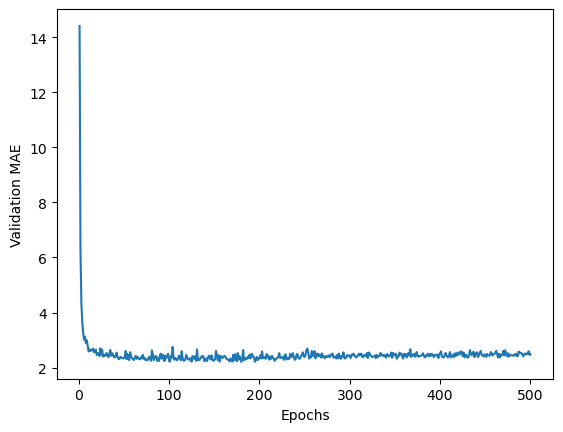

In [4]:
#繪製圖表
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [5]:
test_scores = model.evaluate(test_data, test_targets)
print(test_scores)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.0511 - mean_absolute_error: 2.7146 - mean_absolute_percentage_error: 13.0185 - root_mean_squared_error: 3.5942
[31.364225387573242, 2.892301559448242, 13.805865287780762, 4.053891658782959]


In [6]:
# 訓練最終模型
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=32, verbose=0)

# 使用 model.evaluate() 取得測試集的指標
test_scores = model.evaluate(test_data, test_targets)

# 使用 model.evaluate() 取得訓練集的指標
train_scores = model.evaluate(train_data, train_targets)

# 列印訓練集的指標
print("Train Loss:", train_scores[0])
print("Train MAE:", train_scores[1])
print("Train MAPE:", train_scores[2])
print("Train RMSE:", train_scores[3])
print("----------------------------------")
# 列印測試集的指標
print("Test Loss:", test_scores[0])
print("Test MAE:", test_scores[1])
print("Test MAPE:", test_scores[2])
print("Test RMSE:", test_scores[3])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2362 - mean_absolute_error: 2.3191 - mean_absolute_percentage_error: 12.0880 - root_mean_squared_error: 3.1688
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2975 - mean_absolute_error: 1.3374 - mean_absolute_percentage_error: 6.5989 - root_mean_squared_error: 1.8110 
Train Loss: 3.6462037563323975
Train MAE: 1.4397270679473877
Train MAPE: 7.052082538604736
Train RMSE: 1.924911379814148
----------------------------------
Test Loss: 26.006988525390625
Test MAE: 2.5504629611968994
Test MAPE: 13.429988861083984
Test RMSE: 3.694955587387085


In [7]:
# 設定要列印的行數
num_rows_to_print = 10

# 使用訓練好的模型對測試集進行預測
predictions = model.predict(test_data)

# 列印實際值和預測值
print("實際值\t\t預測值")
for i in range(num_rows_to_print):
    print(f"{test_targets[i]}\t{predictions[i][0]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
實際值		預測值
7.2	8.742086410522461
18.8	19.28753662109375
19.0	21.489946365356445
27.0	32.679481506347656
22.2	25.069978713989258
24.5	22.55161476135254
31.2	30.134328842163086
22.9	23.12787437438965
20.5	19.393857955932617
23.2	21.929960250854492
